## Algorithm Framework Sandbox

**Context:** In order to iterate quickly on algorithm development, it will be useful to have a basic strategy template that can be adapted to each use case. This will likely be an object-oriented framework, similar to the QuantConnect LEAN framework, although a functional paradigm may work as well. The purpose of this notebook is to be able to build up framework components and see the data in real time.

_Author: Matthew Garton_

In [4]:
import os
import numpy as np
import pandas as pd
from alpha_vantage.techindicators import TechIndicators
from utils.data_ingestion import get_stock_prices

### Basic Framework Explained

The framework(s) should work as follows. For now the most practical solution appears to be to treat single asset strategies different from multi-asset ones. For single asset strategies, we set buy/sell signals and maintain a portfolio between `long_tolerance` and `short_tolerance` based on signals and risk management rules. For multi-asset strategies, we use the portfolio approach, setting the hedge ratio or portfolio weights based on regression or kalman filters.

Single asset:  
`input` --> time series dataframe with prices and any other features  
`output` --> signal indicating desired position for asset

Multi asset:  
`input` --> time series dataframe with price series for assets  
`output` --> portfolio weights for each asset

In [5]:
class Strategy:
    def __init__(self, symbol):
        self.symbol = symbol
    
    @staticmethod
    def generate_signals(self, data):
        self.data = data
        return np.zeros(data.shape[0])

In [26]:
class BollingerBandStrategy(Strategy):
    def __init__(self, symbol):
        self.symbol = symbol
    
    def generate_signals(self, data):
        ti = TechIndicators(key=os.getenv('ALPHAVANTAGE_API_KEY'), output_format='pandas')
        bb, meta = ti.get_bbands(symbol=self.symbol, interval='daily', time_period=data.shape[0])
        
        # TODO: broadcast via numpy array
        signals = np.zeros(data.shape[0])
        signals = -1 * (data > bb) + 1 * (data < bb)
        
        return signals

In [27]:
bbstrat = BollingerBandStrategy('SPY')

In [28]:
spy = get_stock_prices('SPY', source='av')

In [31]:
spy['close']

date
1999-11-01    135.562500
1999-11-02    134.593704
1999-11-03    135.500000
1999-11-04    136.531204
1999-11-05    137.875000
                 ...    
2021-05-19    410.860000
2021-05-20    415.280000
2021-05-21    414.940000
2021-05-24    419.170000
2021-05-25    418.240000
Name: close, Length: 5426, dtype: float64

In [32]:
spy['signal'] = bbstrat.generate_signals(spy['close'].values)

ValueError: Unable to coerce to Series, length must be 3: given 5426

In [33]:
bbstrat.generate_signals(spy['close'].values)

ValueError: Unable to coerce to Series, length must be 3: given 5426

In [40]:
ti = TechIndicators(key=os.getenv('ALPHAVANTAGE_API_KEY'), output_format='pandas')
bb, meta = ti.get_bbands(symbol='SPY', interval='daily', time_period=20)

In [41]:
bb

,Real Middle Band,Real Lower Band,Real Upper Band
date,,,
2021-05-25,415.7945,408.2682,423.3208
2021-05-24,415.7585,408.2725,423.2445
2021-05-21,415.6805,408.3067,423.0543
2021-05-20,415.7705,408.3911,423.1499
2021-05-19,415.6200,408.0856,423.1544
...,...,...,...
1999-12-03,94.2033,91.6724,96.7343
1999-12-02,93.9581,91.4009,96.5154
1999-12-01,93.7653,90.9050,96.6257


In [45]:
data = spy.join(bb).dropna()

In [47]:
data

,open,high,low,close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
1999-11-29,140.875000,141.921799,140.437500,140.937500,94.515595,7348600.0,0.0,1.0,93.4457,90.0105,96.8810
1999-11-30,140.750000,142.312500,139.000000,139.281204,93.404848,7682000.0,0.0,1.0,93.5704,90.3371,96.8037
1999-12-01,139.312500,140.500000,139.000000,140.406204,94.159297,6980200.0,0.0,1.0,93.7653,90.9050,96.6257
1999-12-02,140.625000,141.375000,140.375000,141.250000,94.725164,6698300.0,0.0,1.0,93.9581,91.4009,96.5154
1999-12-03,143.031204,145.343704,143.031204,143.843704,96.464555,10045400.0,0.0,1.0,94.2033,91.6724,96.7343
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-19,406.920000,411.050000,405.330000,410.860000,410.860000,106467052.0,0.0,1.0,415.6200,408.0856,423.1544
2021-05-20,411.800000,416.625000,411.670000,415.280000,415.280000,78022218.0,0.0,1.0,415.7705,408.3911,423.1499
2021-05-21,416.870000,418.200000,414.450000,414.940000,414.940000,76578662.0,0.0,1.0,415.6805,408.3067,423.0543


In [48]:
def bb_signal(val, upper, lower):
    if val > upper:
        return 1
    elif val < lower:
        return -1
    else:
        return 0

data['signal'] = data.apply(
    lambda x: bb_signal(
        x['5. adjusted close'],
        x['Real Upper Band'],
        x['Real Lower Band']
    ),
    axis=1
)

In [50]:
sum(data.signal)

-17

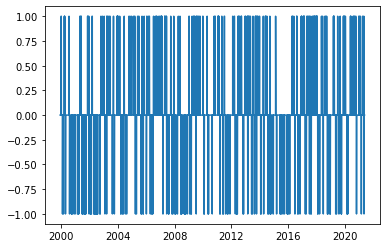

In [52]:
import matplotlib.pyplot as plt
plt.plot(data.signal)